# Setup

In [1]:
# Local Utils
# sys.path.insert(0, "/glade/work/zespinosa/Projects/climate-utils")
# from utils import (
#     plot_stationary_sp,
# )

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cmocean
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


# Plotting Utils

In [2]:
def plot_stationary_sp(nplots: int = 3, minLon: int = -180, maxLon: int = 180):
    """
    TODO: Add Doc String
    Create a stationary centered on south pole (Longitude: [minLon,maxLon]; Latitude: [-90,-60]
    Returns:
        ax, fig
    """
    # Create subplots
    if nplots == 3:
        figsize = [20, 20]
    if nplots == 2:
        figsize = [10, 10]
    if nplots == 1:
        figsize = [5, 5]

    fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=figsize, subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.15)

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if nplots == 1:
        axs =  [axs]

    # Add properties to axes
    for ax in axs:
        # Limit the map to -60 degrees latitude and below.
        ax.set_extent([minLon, maxLon, -90, -50], ccrs.PlateCarree())

        ax.gridlines(draw_labels=True, color="black", linestyle="dashed", zorder=101)
        ax.tick_params(which="both", zorder=103)

        ax.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)
        ax.add_feature(cartopy.feature.OCEAN, facecolor="white")


        ax.set_boundary(circle, transform=ax.transAxes)

    return fig, axs


In [117]:
def spatial_obs_plot(dfs, cmap_info, save_info):
    fig, axes = plot_stationary_sp(nplots=len(dfs.keys()))

    for i, ((key, ds), ax) in enumerate(zip(dfs.items(), axes)):

        if not cmap_info["shared"]:
            levels = cmap_info["levels"][i]
            units = cmap_info["units"][i]
            cmap = cmap_info["cmap"][i]
        else: 
            levels = cmap_info["levels"]
            units = cmap_info["units"]
            cmap = cmap_info["cmap"]

        # Create contour plot
        img = ax.contourf(
            ds["ds"].lon.values,
            ds["ds"].lat.values,
            ds["ds"].values,
            transform=ccrs.PlateCarree(), 
            levels=levels,
            extend="both",
            cmap=cmap,
        )
        
        # Add ice edge
        if key == "cesm2_siconc":
            ax.contour(
                ds["edge"].lon.values,
                ds["edge"].lat.values,
                ds["edge"].values,
                transform=ccrs.PlateCarree(), 
                levels=[.15],
                colors="orange"
            )
            ax.contour(
                ds["edge_clim"].lon.values,
                ds["edge_clim"].lat.values,
                ds["edge_clim"].values,
                transform=ccrs.PlateCarree(), 
                levels=[.15],
                colors="blue",
            )



        # Plot Winds if given
        if "wind" in ds.keys():
            lat_step, lon_step = 5, 5 
            ax.quiver(
                x=ds["wind"][0].lon[::lon_step],
                y=ds["wind"][0].lat[::lat_step],
                u=ds["wind"][0].values[::lat_step, ::lon_step], 
                v=ds["wind"][1].values[::lat_step, ::lon_step], 
                color="black", 
                scale=ds["wind"][2],
                transform=ccrs.PlateCarree(),
            )

        if not cmap_info["shared"]:
            cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.046, pad=0.04)
            cbar.ax.set_title(units, fontweight="bold")

        # Set properties
        ax.set_title(ds["title"], loc="left", fontweight="bold")


    if len(dfs) == 3: 
        fraction = .016
    else: 
        fraction = .026

    if cmap_info["shared"]:
        cbar = fig.colorbar(img, ax=axes.ravel().tolist(), orientation="vertical", fraction=fraction, pad=0.04)
        cbar.ax.set_title(cmap_info["units"], fontweight="bold")

    if save_info["save"]:
        plt.savefig(save_info["path"], dpi=save_info["dpi"], bbox_inches="tight")


# Analysis

## Sea Ice Thickness

In [113]:
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")
cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze()

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)


<xarray.DataArray 'aice' (lat: 180, lon: 360)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.74525473, 0.74489688, 0.74454566, ..., 0.74635494, 0.74599008,
        0.74561914],
       [0.74851081, 0.74825357, 0.7479975 , ..., 0.74928873, 0.74902848,
        0.74876914],
       [0.75344069, 0.75327461, 0.75311022, ..., 0.75394858, 0.75377773,
        0.75360842]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 0001-06-01 00:00:00

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)


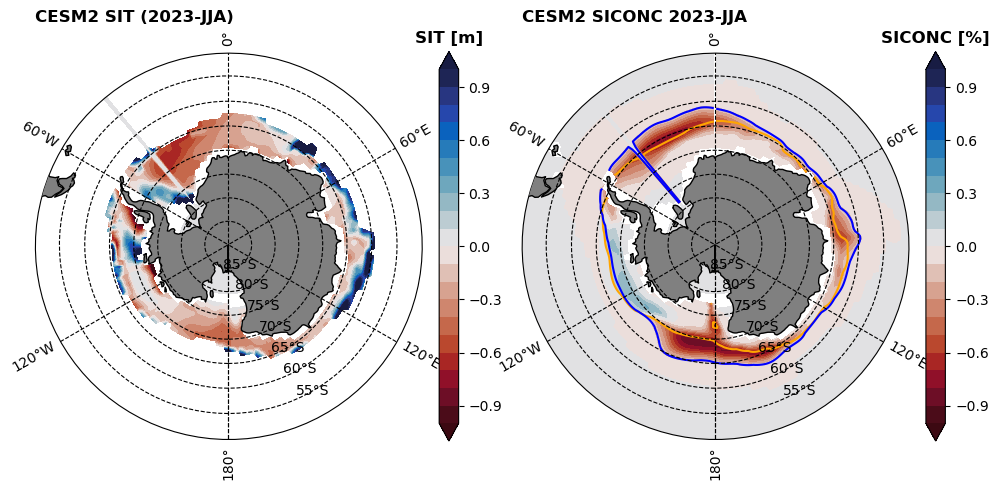

In [118]:
save_info = {
    "save": True,
    "path": "figures/siconc.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["SIT [m]", "SICONC [%]"],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1), np.arange(-1, 1.1, .1)]
}

cesm2_thickness = {
    "title": "CESM2 SIT (2023-JJA)",
    "ds": cesm2_ice_anoms["sithick"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_siconc = {
    "title": "CESM2 SICONC 2023-JJA",
    "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

spatial_obs_plot(
    dfs={
        "cesm2_thickness":  cesm2_thickness, 
        "cesm2_siconc": cesm2_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## ATM

In [41]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")
era5_atm_anoms
# cesm2_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Windspeed

In [23]:
save_info = {
    "save": True,
    "path": "figures/windspeed.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Windspeed 10m [ms$^{-2}$]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    # ERA5 Wind Speed Anomalies JJA 2022
    "ds": era5_atm_anoms["si10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    # CESM2 Wind Speed Anomalies JJA 2022
    "ds": cesm2_atm_anoms["U10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100,
    ]
}

diff = {
    "title": "ERA5 - CESM2", 
    "ds": era5["ds"] - cesm2["ds"],
    "winds": [
        era5["wind"][0] - cesm2["wind"][0],
        era5["wind"][1] - cesm2["wind"][1],
    ]
}

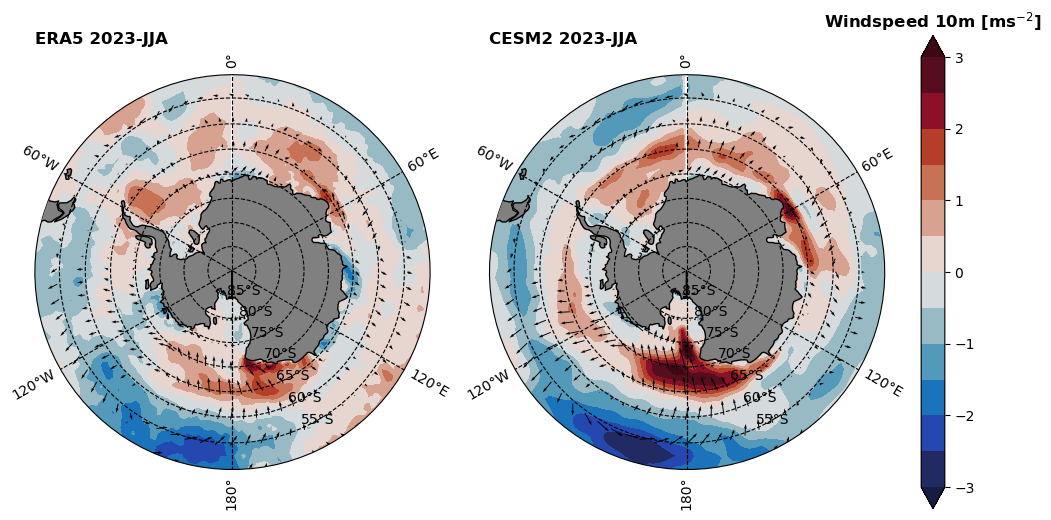

In [24]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### MSLP 

In [87]:
save_info = {
    "save": True,
    "path": "figures/mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}


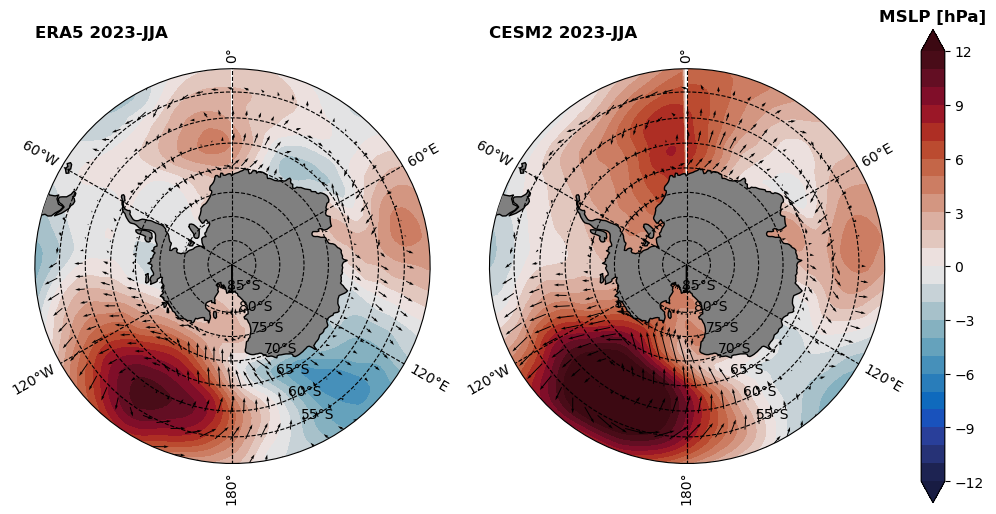

In [88]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### SST

In [43]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
cesm2_sst_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 901)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1949-12-01 1950-01-01 ... 2024-12-01
Data variables:
    SST      (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-10-10 at 16:13:18.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [42]:
era5_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [100]:
save_info = {
    "save": True,
    "path": "figures/sst.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


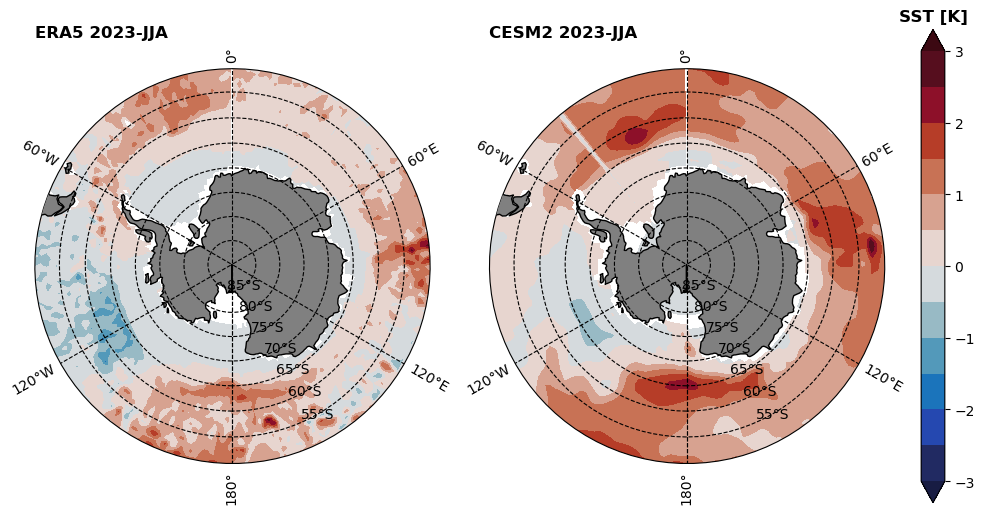

In [101]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [68]:
save_info = {
    "save": True,
    "path": "figures/sst_2023MAM.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-MAM",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-MAM",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}


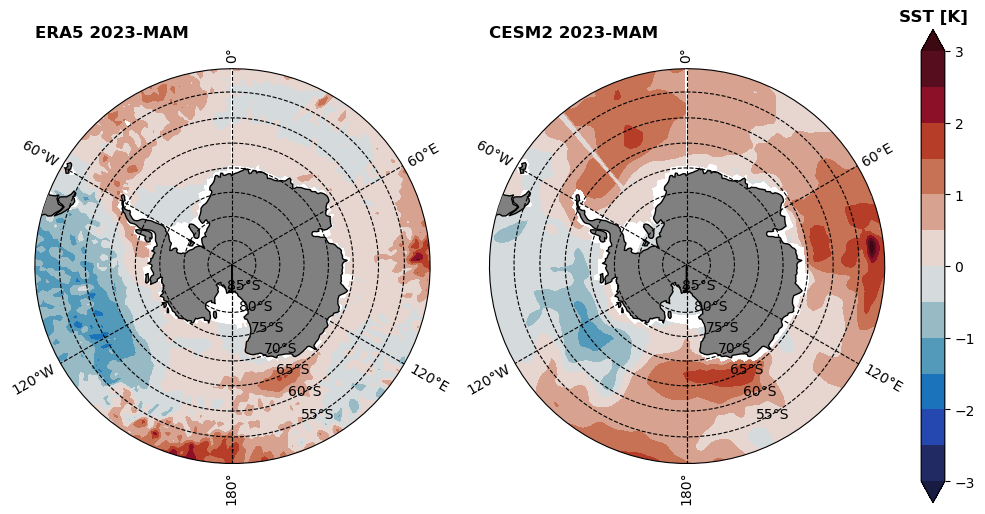

In [69]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [72]:
save_info = {
    "save": True,
    "path": "figures/sst_2023DJF.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-DJF",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-DJF",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}


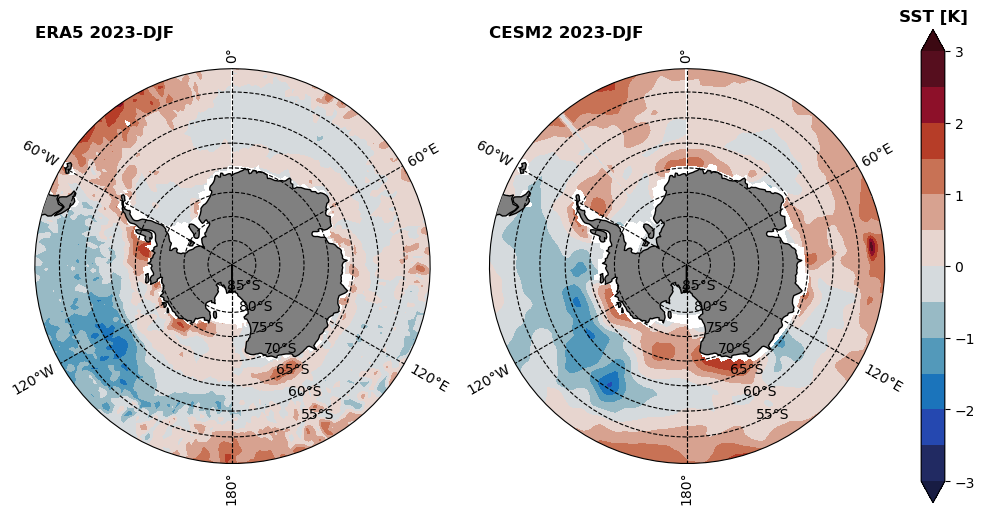

In [73]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [102]:
save_info = {
    "save": True,
    "path": "figures/sst_2022JJA.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2022-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2022-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}


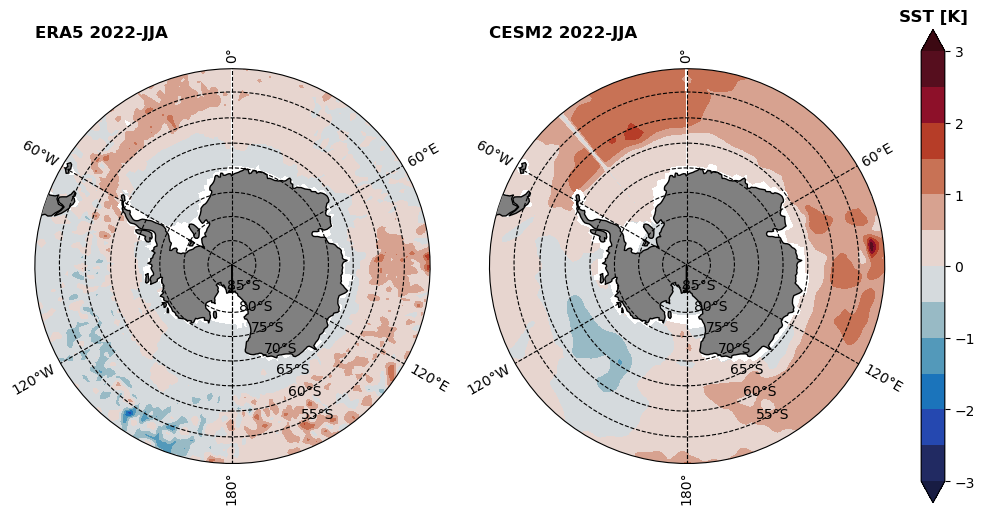

In [103]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Z500

In [126]:
era5_atm_anoms_levels = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-pressure-anoms.nc")
# era5_atm_anoms_levels.sel(level=500)["z"]

# cesm2_atm_anoms["Z3"].isel(lev=2)

<xarray.DataArray 'z' (time: 538, lat: 180, lon: 360)>
[34862400 values with dtype=float64]
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential
    regrid_method:  bilinear
    operation:      temporal_avg
    mode:           departures
    freq:           month
    weighted:       True

In [148]:
save_info = {
    "save": True,
    "path": "figures/z500.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Z500 [$m$]",
    "levels": np.arange(-100, 110, 10),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms_levels.sel(level=500)["z"].sel(time="2023-08").squeeze() / 9.8,
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["Z3"].isel(lev=2).sel(time="2023-08").squeeze(),
}

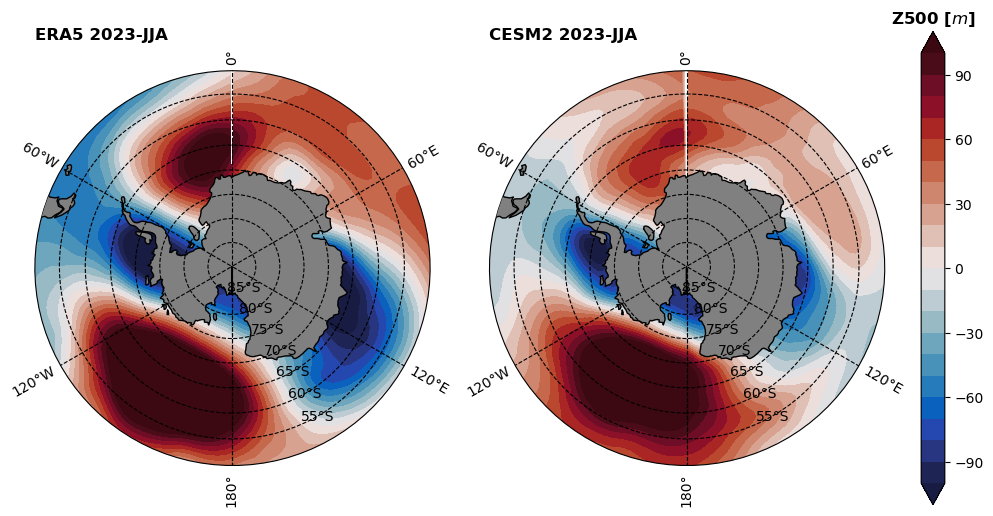

In [149]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### 2TM 

In [120]:
cesm2_atm_anoms
era5_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [60]:
save_info = {
    "save": True,
    "path": "figures/t2m.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"T2M [K]",
    "levels": np.arange(-10, 11, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["t2m"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


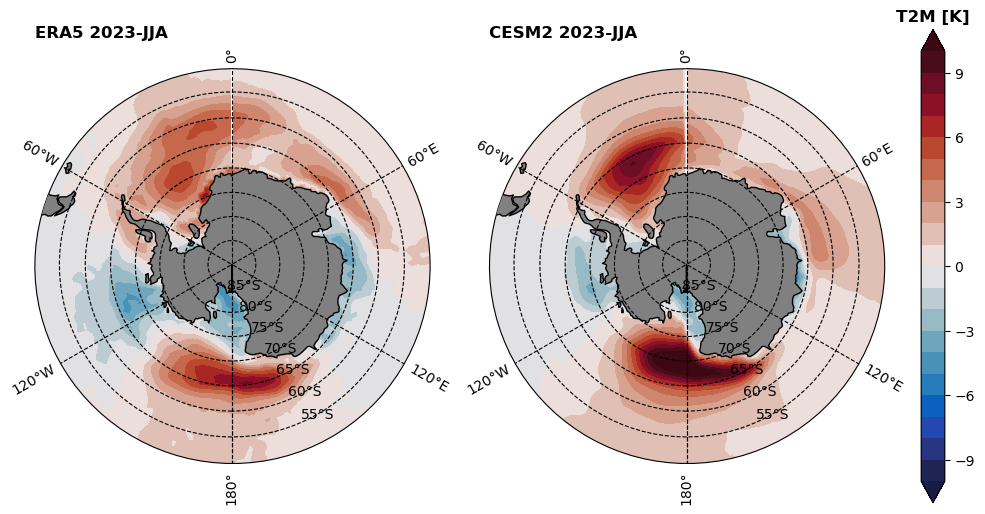

In [61]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Ice

In [77]:
cesm2_ice_anoms

<xarray.Dataset>
Dimensions:  (time: 900, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2024-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    aice     (time, lat, lon) float64 ...
    uvel     (time, lat, lon) float64 ...
    vvel     (time, lat, lon) float64 ...
    dvidtt   (time, lat, lon) float64 ...
    dvidtd   (time, lat, lon) float64 ...
    daidtt   (time, lat, lon) float64 ...
    daidtd   (time, lat, lon) float64 ...
    sithick  (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 19500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2023-10-10 at 16:31
    io_flavor:         io_pio

In [89]:
cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()

<xarray.DataArray (lat: 180, lon: 360)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24603626, -0.24675609, -0.24747885, ..., -0.24371276,
        -0.24460627, -0.24531957],
       [-0.24356075, -0.24299835, -0.24241805, ..., -0.24513714,
        -0.24463043, -0.24410489],
       [-0.26141562, -0.2616543 , -0.26189443, ..., -0.26070882,
        -0.2609428 , -0.26117846]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     datetime64[ns] 2023-06-01

In [96]:
save_info = {
    "save": True,
    "path": "figures/daidt.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

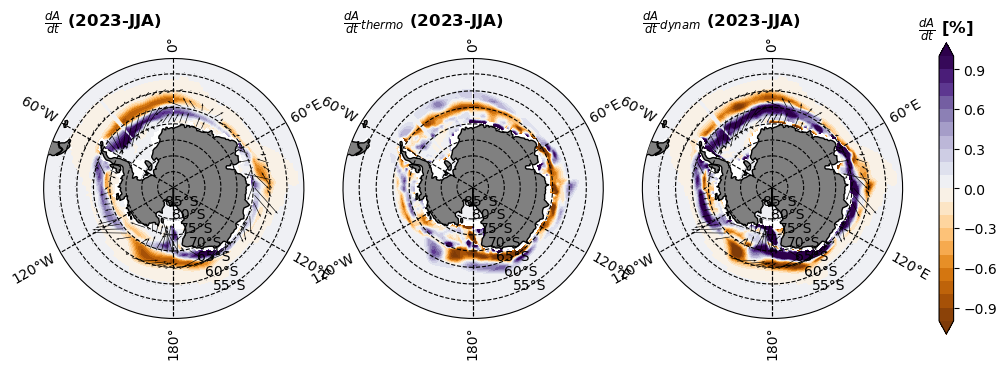

In [99]:
spatial_obs_plot(
    dfs={
        "cesm2_sum": cesm2_sum,
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)